In [1]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
model = load_model('./Model/mask_detection_best.h5')

In [3]:
batch_size = 16
validation_datagen = ImageDataGenerator(rescale = 1.0 / 255)
validation_generator = validation_datagen.flow_from_directory('./Data/val/',
                                                              target_size = (50, 50),
                                                              batch_size = batch_size,
                                                              shuffle = False)

Found 742 images belonging to 2 classes.


In [4]:
validation_generator.reset()
Y_pred = model.predict(validation_generator, 742 // batch_size + 1)
y_pred = np.where(Y_pred > .5, 1, 0)
print(confusion_matrix(validation_generator.classes, y_pred))

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


print(classification_report(true_classes, y_pred, target_names=class_labels))

[[360  11]
 [  3 368]]
              precision    recall  f1-score   support

   with_mask       0.99      0.97      0.98       371
without_mask       0.97      0.99      0.98       371

    accuracy                           0.98       742
   macro avg       0.98      0.98      0.98       742
weighted avg       0.98      0.98      0.98       742



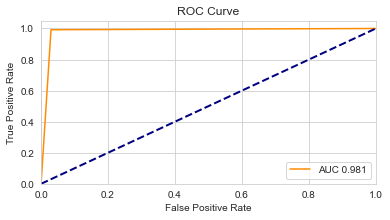

In [5]:
fpr, tpr, _ = roc_curve(validation_generator.classes, y_pred)
roc_auc = round(auc(fpr, tpr),3)
plt.figure(figsize=(6,3))
plt.plot(fpr, tpr, color='darkorange',
label='AUC ' + str(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw= 2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

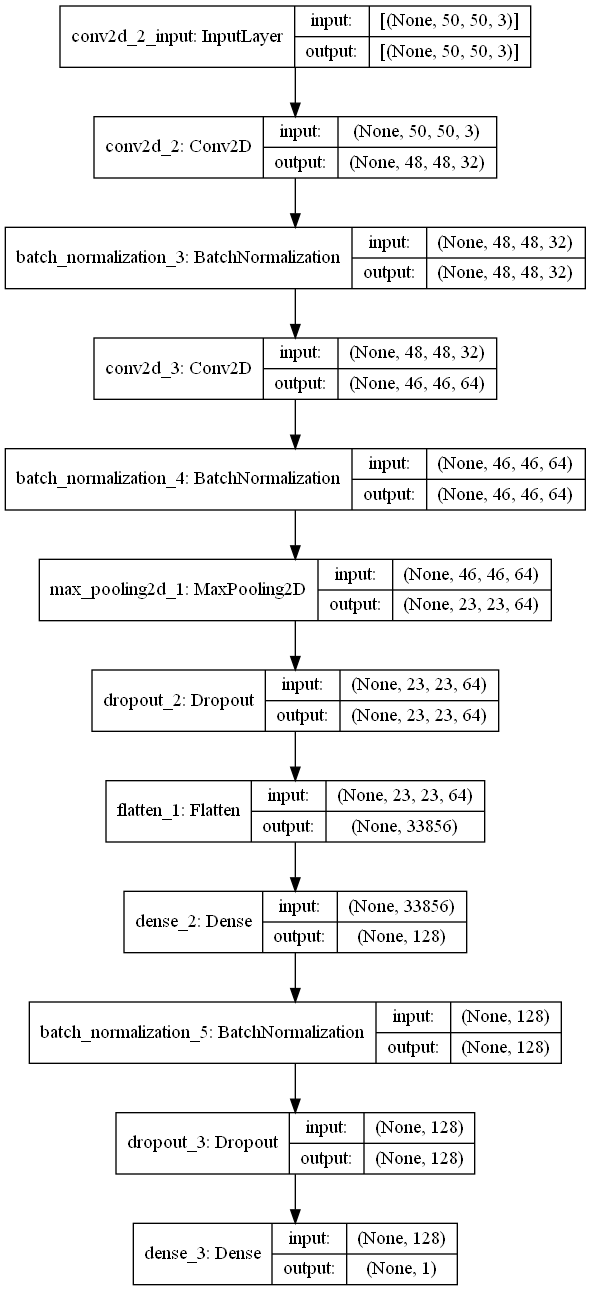

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Model\model_plot.png',show_shapes=True,show_layer_names=True)

In [13]:
img_paths = [file for file in glob.glob(r'./Data/val/with_mask/*')]

false_negative_imgs = []

for image_file in img_paths:
    img = load_img(image_file, target_size=(50,50))
    x = img_to_array(img)
    x = x/255.
    x = x.reshape(1,50,50,3)
    pred = model.predict(x)
    pred = np.where(pred > .5, 1, 0)[0][0]
    if pred == 1:
        false_negative_imgs.append(image_file)

In [15]:
img_paths = [file for file in glob.glob(r'./Data/val/without_mask/*')]

false_positive_imgs = []

for image_file in img_paths:
    img = load_img(image_file, target_size=(50,50))
    x = img_to_array(img)
    x = x/255.
    x = x.reshape(1,50,50,3)
    pred = model.predict(x)
    pred = np.where(pred > .5, 1, 0)[0][0]
    if pred == 0:
        false_positive_imgs.append(image_file)

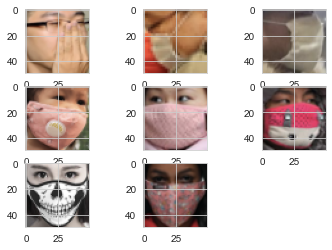

In [11]:
for i,j in zip(range(331, 339), range(len(false_negative_imgs))):
    plt.subplot(i)
    img = cv2.imread(false_negative_imgs[j])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)

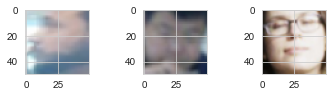

In [17]:
for i,j in zip(range(331, 339), range(len(false_positive_imgs))):
    plt.subplot(i)
    img = cv2.imread(false_positive_imgs[j])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)

The False negatives images are likely due to two factors: Mask design and color.
Unique designs are not the norm, so there is probably not enough training data to account for designs.
The model also seems to have a hard time identifying pink masks. This is probably because of skin tone.

The False positives are likely due to bad images. They all seem pretty blurry.